### Mounting your google drive on Colab Noetebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
## remplazá 'workshopml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/workshopml/ML_workshop2020/  
datapath = './data/clinvarHC_modeling.csv.gz'
targetname = 'ClinvarHC'

/content/drive/My Drive/workshopml/ML_workshop2020


In [2]:
%matplotlib inline

# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from IPython.display import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load and split data

In [40]:
SEED = 2718281
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt',nrows=500)
X,y = data.drop([targetname],axis = 1), data[[targetname]]

## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)


### Preprocessing

In [41]:
categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)] # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])


### Qué quiero ver: 

* Optimización de hyperparámetros : gridsearch

* Convencernos que L1 mata features correlacionados y L2 distribuye los pesos

* Recursive feature elimination

* Utilizando L1 (que tiende a matar features correlacionados): sparsity 

* Nro features (y cuáles) en términos de C. 




## Model

In [44]:
### Construimos el Pipeline
## Regresion Logistica 
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear',max_iter=1000))])  
#especificamos el solver para evitar warnings


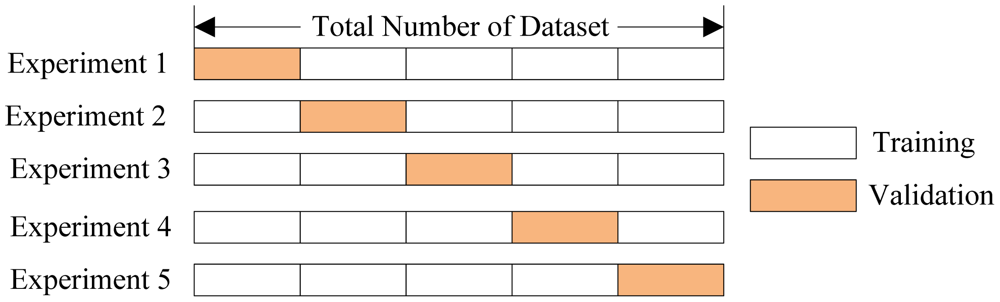

In [ ]:
Image(filename = "./images/CrossValid.png", width=600, height=400)

In [121]:
#lr_C =  [0.1,1,10]
lr_C =  [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]

param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1']}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, y_train[targetname].ravel())


bestpipe = search.best_estimator_  ## Nuestro pipeline se usó localmente. Con esta línea le paso la configuración óptima de la búsqueda
############
# y si usamos average_precision?
#search = GridSearchCV(pipeline, param_grid, 
#                      cv=2,return_train_score = True,
#                     scoring = 'average_precision').fit(X_train, y_train.ClinvarHC.ravel())

* GridSearchCV No retiene explícitamente los modelos generados (i.e. , sus coeficientes) en cada combinación de parámetros de la grilla de búsqueda. 



* Sólo retiene los scores de cada modelo generado, y los parámetros del modelo de "mejor performance" acorde al criterio por default (maximizar el score medio en el evaluation set)



### Cómo le va en performance?

Text(0.5, 0, 'regularization parameter')

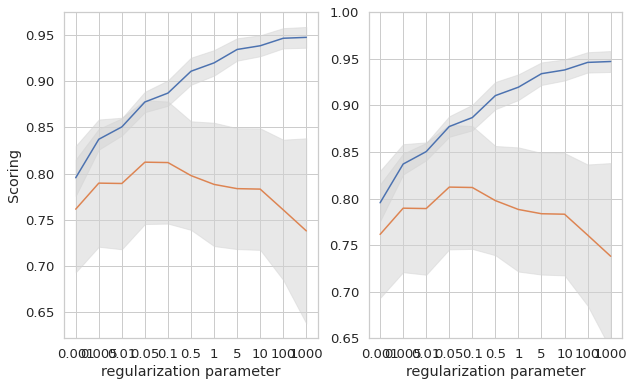

In [123]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score','std_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()  # esta línea es compleja. Es una manera eficiente de parsear los diccionarios que tenemos en el objeto results. 
# Y llevarla a un dataframe. Para entenderla después tranquilos exploren el objeto 'results'


performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)

ylow_train =   perf_train - performance.std_train_score
yup_train = perf_train + performance.std_train_score

ax1.fill_between(performance.C, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ylow_test =   perf_test - performance.std_test_score
yup_test = perf_test + performance.std_test_score

ax1.fill_between(performance.C, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')



ax1.set_ylabel('Scoring')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax2.fill_between(performance.C, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax2.set_ylim([0.65,1])


ax2.set_xlabel('regularization parameter')



### Notar que: 
* Fijensé que para valores de C ariba de 1, la performance en el training y en el evaluation set , se empiezan a separar (los intervalos de confianza dejan de superponerse). Osea, sobreajuste seguro. 

* Las medias empiezan a abrirse en 0.1
* No obstante, nuestro máximo está en 0.5. Tomamos ese? 0.1? Las diferencias en performance son significativas?



In [63]:
numerical_names = bestpipe.named_steps['preprocessing'].transformers[0][2].tolist()
categorical_output_names = bestpipe.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names  # ver nota abajo

search.best_estimator_['clasificador']

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

###############################################################################
* C= 0.5 está ok?
* Qué implicancia tiene en el modelo si lo vemos en términos de selección de variables?
################################################################################





###########################################################################
### Entreno modelos para cada valor de C (sin CV, usando todo el train):
###########################################################################


* Esto nos va a permitir analizar los coeficientes de cada modelo, en particular cuantas variable 'mató' (tiró a cero).

In [124]:
sparsity_l1_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l1'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train[targetname].ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l1_LR.update({Id: sparc})

sparsity = pd.Series(sparsity_l1_LR)

0.001
0.005
0.01
0.05
0.1
0.5
1
5
10
100
1000


Text(0, 0.5, 'regularization parameter')

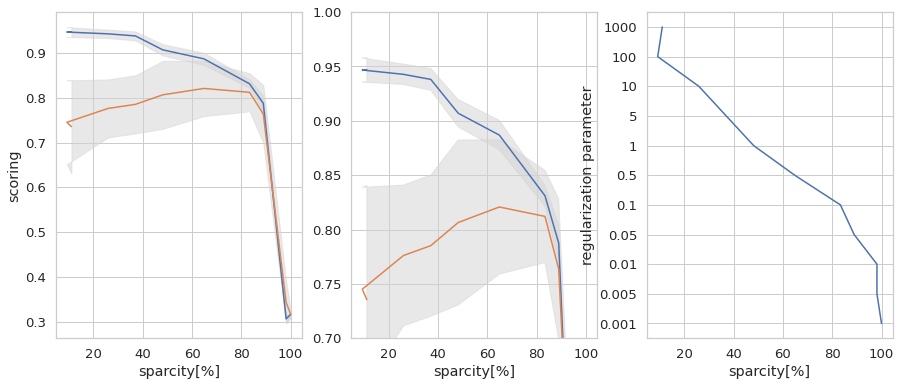

In [102]:
matplotlib.rcParams['figure.figsize'] = [15, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score','std_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(sparsity, performance.mean_train_score)
ax1.plot(sparsity, performance.mean_test_score)



ylow_train =   perf_train - performance.std_train_score
yup_train = perf_train + performance.std_train_score

ax1.fill_between(sparsity, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')


ylow_test =   perf_test - performance.std_test_score
yup_test = perf_test + performance.std_test_score

ax1.fill_between(sparsity, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')


ax1.set_ylabel('scoring')
ax1.set_xlabel('sparcity[%]')


ax2.plot(sparsity, performance.mean_train_score)
ax2.plot(sparsity, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(sparsity, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax2.fill_between(sparsity, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')


ax2.set_ylim([0.7,1])
ax2.set_xlabel('sparcity[%]')



ax3.plot(sparsity,performance.C)
ax3.set_xlabel('sparcity[%]')
ax3.set_ylabel('regularization parameter')




* De 0.1 a 1, la cantidad de features considerados aumenta drásticamente!!

(spacity pasa aprox de un 80 a un 50%).



## Lo que viene abajo 
* es para calcular la significancia estadística entre las diferencias de AUC ROC halladas en C = 0.1 y C = 0.5. Nada mejor que el paquete pROC de R para esas cosas (tiene varias implementaciones para comparar AUCs). 
* si descomentan y corren van a estar llamando a R desde acá (python). Es medio chino pero en ocaciones amerita. Lo dejo para los que no lo conzcan, porque si en otra ocación necesitan unir lo mejor de esos dos mundos en un mismo notebook
* Las fierencias en el test en C = 0.5 o C = 0.1 no son significativas

In [108]:
#import rpy2 as r2p
#import rpy2.robjects as ro
#from rpy2.robjects.packages import importr
#import rpy2.robjects.numpy2ri
#rpy2.robjects.numpy2ri.activate()


#ro.r('''
#install.packages('pROC')
#library('pROC')
#roctest<- function(y,pred1,pred2){
#  rroc1 = roc(y,pred1)
#  rroc2 = roc(y,pred2)
#  signif <- pROC::roc.test(rroc1,rroc2)
#  return(signif)
#}
#''')
#pROC = importr('pROC')

#roctest = ro.globalenv['roctest']


#m05 = model['0.5'].predict_proba(X_train)
#m01 = model['0.1'].predict_proba(X_train)

#signif = roctest(y_train[targetname].values,m01[:,1],m05[:,1])
#pv = signif.rx('p.value')[0]
#print(pv)


## Hay diferencias significatias en los resultados obtenidos con C= 0.1 y C = 0.5 ? 

#* Hay algo mal acá... estoy viendo las diferencias del en el mismo lugar que entreno, osea equivale a ver las diferencias en la curva azul, no en la narajna.
# Tiene formato de código

### En el testing también da significativo (un poco menos, tiene sentido)
## Qué está mal de hacerlo así? 
## Cómo es la forma correcta?


#t01 = model['0.1'].predict_proba(X_test)
#t1 = model['0.5'].predict_proba(X_test)
#signif = roctest(y_test[targetname].values,t01[:,1],t1[:,1])
#pv = signif.rx('p.value')[0]
#print(pv)

##  Exploremos algunos features


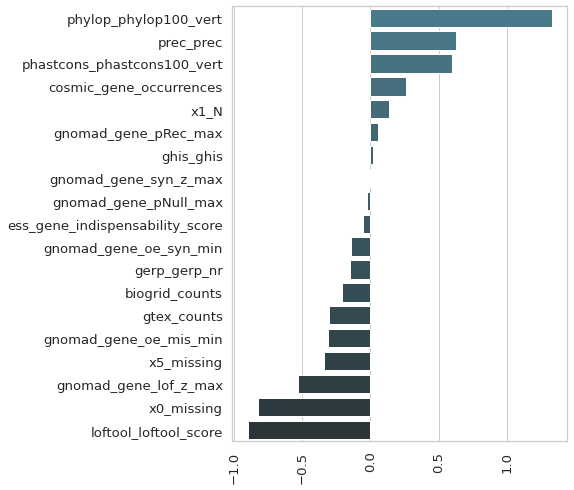

In [103]:
matplotlib.rcParams['figure.figsize'] = [6,8]
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
coefs = pd.Series(model['0.5']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

## No me parece menor la observacion de que, sobrevivieron features de distinta naturaleza: 
*  Conservación (phylop, phascons)
*  inferencia de loss of function (gnomad lof_z, loftool,)
*  Expresión en tejidos (gtex_counts)
*  Interpro domains (X0_missing). Osea, que la variante caiga fuera de un dominio estructural es informativo
*  Biogrid (ppi networks)

# Cuál es la performance del modelo?

In [109]:
ypred_test = model['0.5'].predict_proba(X_test)[:,1]
print('AUC ROC %s'%metrics.roc_auc_score(y_test,ypred_test))
print('Average Precision %s'%metrics.average_precision_score(y_test,ypred_test))

AUC ROC 0.888888888888889
Average Precision 0.8149243732392895


### Que pasa si usamos L2?
* Sparsity? 
* Performance?
* Redundancia? Robustez?

In [126]:

pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  

param_grid = [ {'clasificador__C':lr_C, 'clasificador__penalty': ['l2']} ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, y_train.ClinvarHC.ravel())

sparsity_l2_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l2'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train.ClinvarHC.ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l2_LR.update({Id: sparc})

    
sparsity = pd.Series(sparsity_l2_LR)

0.001
0.005
0.01
0.05
0.1
0.5
1
5
10
100
1000


Text(0.5, 0, 'regularization parameter')

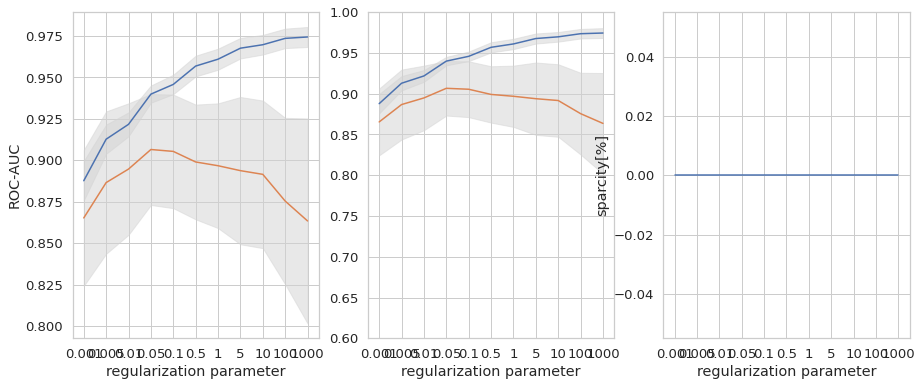

In [127]:

matplotlib.rcParams['figure.figsize'] = [15,6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score','std_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score


ylow_train =   perf_train - performance.std_train_score
yup_train = perf_train + performance.std_train_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)

ax1.fill_between(performance.C, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ylow_test =   perf_test - performance.std_test_score
yup_test = perf_test + performance.std_test_score

ax1.fill_between(performance.C, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)


ax2.fill_between(performance.C, ylow_train, yup_train,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.fill_between(performance.C, ylow_test, yup_test,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax2.set_ylim([0.6,1])
ax2.set_xlabel('regularization parameter')

ax3.plot(performance.C,sparsity)
ax3.set_ylabel('sparcity[%]')
ax3.set_xlabel('regularization parameter')

In [ ]:
##### Recompute models



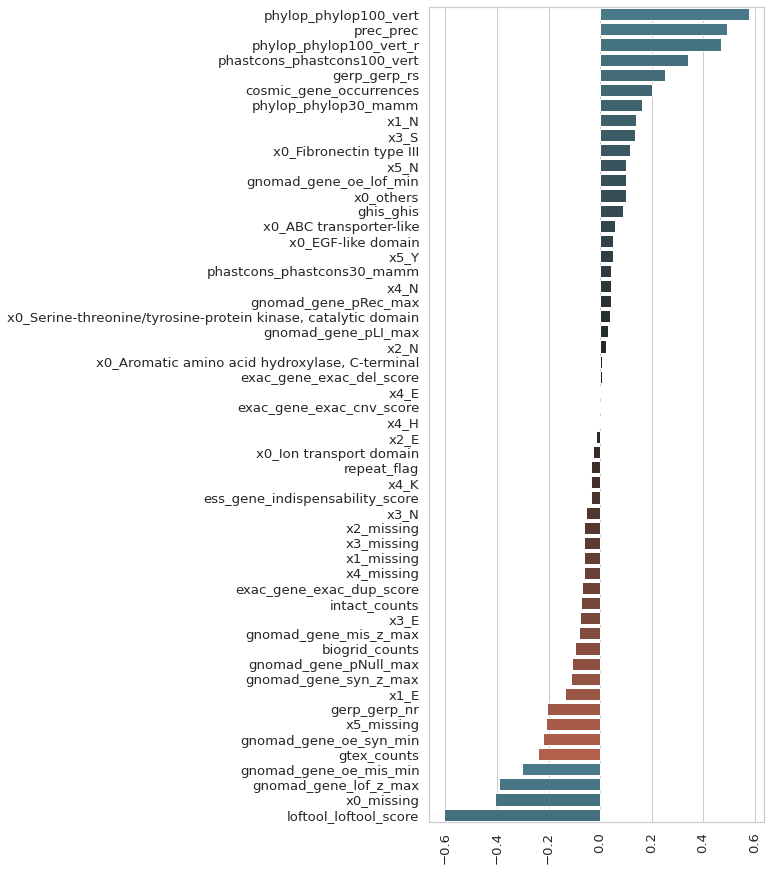

In [128]:
matplotlib.rcParams['figure.figsize'] = [6,15]
sns.set_style("whitegrid")
coefs = pd.Series(model['0.1']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

# Recursive Feature Elimination?

### Que tenemos?
* a la cabeza, conservación con approache filogenético --variant fetaure--
* Expresión diferencial (gtex) --gene fetaure-- 
* Loss of function --gene fetaure--?
* gnomad, loss of funcion z-score  --gene fetaure--
* Intepro domain (falta de)  --Protein fetaure--
* Inferencia recesive gene
* gnomad max O/E missense per gene. 

##### En menor medida:



###  Raro que  Non Essenctial categories salgan con coeficientes positivos. 
* raro biogrid también

# veamos otra relacion items vs columsn


In [ ]:
X_subtrain, _, y_subtrain, _ = train_test_split(X_train, y_train, test_size=0.96, random_state=SEED,stratify = y_train)
X_subtrain.shape


(346, 39)

In [ ]:
#lr_C =  [0.1,1,10]
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  
lr_C =  [0.00000001,0.0001,0.001,0.01,0.1,1,10,100,500,1000]


param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1'], 'clasificador__max_iter': [3000]}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'average_precision').fit(X_subtrain, y_subtrain[targetname].ravel())


#pipeline = search.best_estimator_  ## Nuestro pipeline se usó localmente. Con esta línea le paso la configuración óptima de la búsqueda

In [ ]:
search.best_score_

0.7671481629590352

Text(0.5, 0, 'regularization parameter')

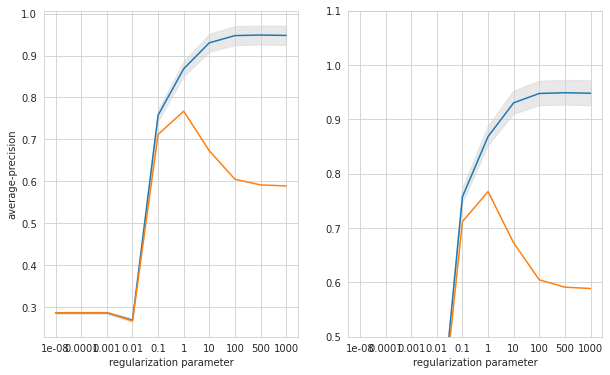

In [ ]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('average-precision')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.5,1.1])

ax2.set_xlabel('regularization parameter')
